In [1]:
import boto3
import pandas as pd
import io

# AWS S3 Credentials
aws_access_key_id = 'YOUR_KEY_ID'
aws_secret_access_key = 'YOUR_ACCESS_KEY'
endpoint_url = 'YOUR_ENDPOINT'
bucket_name = 'fred'

s3 = boto3.resource(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    endpoint_url=endpoint_url
)
bucket = s3.Bucket(bucket_name)

def s3_csv_to_df(key: str) -> pd.DataFrame:

    body = bucket.Object(key).get()["Body"].read()
    return pd.read_csv(io.BytesIO(body))

In [2]:
import pandas as pd
from functools import reduce

kpi_files = {
    'DCOILWTICO.csv': 'crude_oil_price',
    'CPIAUCSL.csv': 'cpi',
    'GASREGW.csv': 'retail_gas_price',
    'GDP.csv': 'gdp',
    'INDPRO.csv': 'indpro',
    'PPIACO.csv': 'ppi',
    'TWEXAFEGSMTH.csv': 'usd_index',
    'UNRATE.csv': 'unrate'
}

def load_and_merge_data():
    dfs = []
    for key, col_name in kpi_files.items():
        try:
            df = s3_csv_to_df(f"observations/{key}")   
        except Exception as e:
            print(f" {key} missing → {e}")
            continue

        df.columns = df.columns.str.strip().str.lower()
        date_col  = 'observation_date' if 'observation_date' in df.columns else 'date'
        value_col = 'value' if 'value' in df.columns else next(c for c in df.columns if c != date_col)

        df = (
            df[[date_col, value_col]]
              .rename(columns={date_col: 'date', value_col: col_name})
        )
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').resample('W').ffill().reset_index()
        dfs.append(df)

    if not dfs:
        raise RuntimeError("No KPI files were loaded from S3 — nothing to merge.")

    merged_df = reduce(lambda l, r: pd.merge(l, r, on='date', how='inner'), dfs)
    return merged_df.sort_values('date').reset_index(drop=True)



C:\Users\flore\AppData\Local\Temp\ipykernel_14380\3682020105.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lumber_returns = df['crude_oil_price'].pct_change().dropna()


Probability of price increase: 52.44%
Probability of price decrease: 47.56%


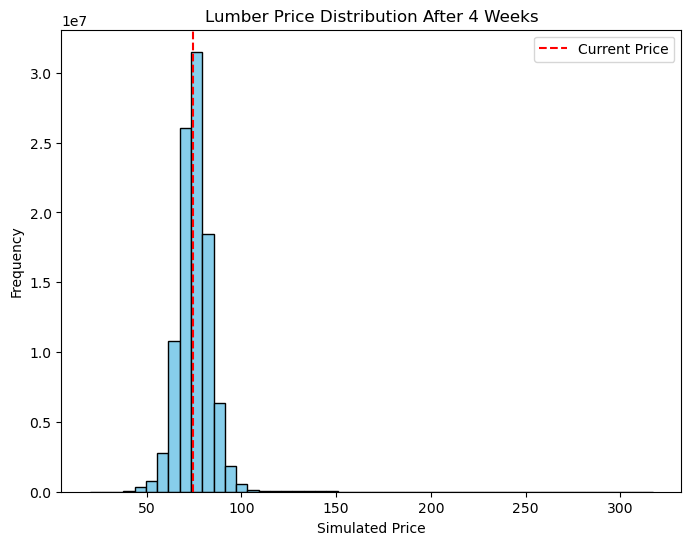

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp

df = load_and_merge_data()
lumber_returns = df['crude_oil_price'].pct_change().dropna()

np.random.seed(42)
num_simulations = 100000000
future_weeks = 4 # 1 = 7 Days 
final_prices = []

returns_matrix = cp.random.choice(cp.asarray(lumber_returns), size=(num_simulations, future_weeks), replace=True)
simulated_paths = cp.prod(1 + returns_matrix, axis=1)
final_prices = cp.asnumpy(df['crude_oil_price'].iloc[-1] * simulated_paths)

current_price = df['crude_oil_price'].iloc[-1]
up_prob = np.mean(np.array(final_prices) > current_price)
down_prob = 1 - up_prob

print(f"Probability of price increase: {up_prob:.2%}")
print(f"Probability of price decrease: {down_prob:.2%}")

plt.figure(figsize=(8,6))
plt.hist(final_prices, bins=50, color='skyblue', edgecolor='black')
plt.axvline(current_price, color='red', linestyle='--', label='Current Price')
plt.title(f"Lumber Price Distribution After {future_weeks} Weeks")
plt.xlabel('Simulated Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
import pandas as pd, pathlib, textwrap

out_dir = pathlib.Path("data"); out_dir.mkdir(exist_ok=True)

pd.DataFrame({"sim_price": final_prices}).to_csv(out_dir / "lumber_mc.csv",
                                                 index=False)

(out_dir / "lumber_mc_flag.txt").write_text(str(int(up_prob > 0.5)))


1

In [8]:
plt.savefig("lumber_mc_hist.png", dpi=150, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>